# We will try an XgBoost model 
-   Why? : We selected XGBoost as our primary modeling approach due to its state-of-the-art performance on high-dimensional tabular chemoinformatic data, where it significantly outperforms traditional methods like SVMs by efficiently navigating sparse 2048-bit molecular fingerprints. Its tree-based architecture excels at capturing complex non-linear structure-activity relationships (SAR) essential for toxicology, while its native `scale_pos_weight` parameter critically addresses the dataset’s extreme 12:1 class imbalance, allowing us to prioritize the detection of toxic compounds (high recall) without relying on noise-inducing synthetic data generation.

## 1- Imports

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt

## 2- Load the preprocessed dataset 


In [8]:

df_train = pd.read_csv('C:\\Users\\jmurd\\OneDrive\\Escritorio\\UPV\\2025-2026 (NTNU)\\Data Science\\Proyecto\\ClinTox\\data\\train_augmented.csv')
df_valid = pd.read_csv('C:\\Users\\jmurd\\OneDrive\\Escritorio\\UPV\\2025-2026 (NTNU)\\Data Science\\Proyecto\\ClinTox\\data\\valid_augmented.csv')
df_test = pd.read_csv('C:\\Users\\jmurd\\OneDrive\\Escritorio\\UPV\\2025-2026 (NTNU)\\Data Science\\Proyecto\\ClinTox\\data\\test_augmented.csv')

print(f" Train: {df_train.shape}")
print(f" Valid: {df_valid.shape}")
print(f" Test:  {df_test.shape}")




 Train: (1257, 15)
 Valid: (114, 15)
 Test:  (106, 15)


### Now we will generate the fingerprints:

The Role of Molecular Fingerprints

Molecular fingerprints, such as Morgan Fingerprints (ECFP), are the critical bridge that translates raw chemical text (SMILES) into a machine-readable binary language. They work by scanning the molecule to detect specific substructures, like aromatic rings, halogens, or reactive groups, and encoding their presence into a fixed-length vector (e.g., 2048 bits). For XGBoost, these fingerprints are invaluable because they allow the algorithm to go beyond general properties (like weight or solubility) and pinpoint exact structural motifs ("toxicophores") responsible for toxicity, effectively letting the model "see" the chemical architecture causing the adverse effect.

In [9]:
def add_fingerprints(df, n_bits=2048):
    fps = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
            fps.append(np.array(fp))
        else:
            fps.append(np.zeros(n_bits)) 
            
    df_fps = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(n_bits)])
    df = df.reset_index(drop=True)
    df_fps = df_fps.reset_index(drop=True)
    
    return pd.concat([df, df_fps], axis=1)



## 3- Finally, create the model using train, valid, and test sets with fingerprints

In [10]:
df_train_full = add_fingerprints(df_train)
df_valid_full = add_fingerprints(df_valid)
df_test_full  = add_fingerprints(df_test)

# =============================================================================
# 3. PREPARE DATA FOR MODELING
# =============================================================================
drop_cols = ['SMILES', 'CT_TOX', 'FDA_APPROVED']

# Train
X_train = df_train_full.drop(drop_cols, axis=1)
y_train = df_train_full['CT_TOX']

# Valid
X_valid = df_valid_full.drop(drop_cols, axis=1)
y_valid = df_valid_full['CT_TOX']

# Test
X_test = df_test_full.drop(drop_cols, axis=1)
y_test = df_test_full['CT_TOX']

# Calculate Scale Pos Weight (Only with TRAIN)
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"3. Scale Pos Weight calculated (Train): {scale_weight:.2f}")

# =============================================================================
# 4. TRAIN MODEL ON TRAIN SET
# =============================================================================
print("\n=== Training Model on Train Set ===")

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.7,
    scale_pos_weight=scale_weight,
    objective='binary:logistic',
    eval_metric='aucpr',
    n_jobs=-1,
    random_state=42,
    tree_method='hist'
)

print("Training model...")
model.fit(X_train, y_train)
print("\n=== TRAIN SET EVALUATION ===")

y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= 0.5).astype(int)

train_prauc = average_precision_score(y_train, y_train_proba)
train_rocauc = roc_auc_score(y_train, y_train_proba)

print(f"\nTrain PR-AUC:  {train_prauc:.4f}")
print(f"Train ROC-AUC: {train_rocauc:.4f}")
print("\n--- Classification Report (Train Set) ---")
print(classification_report(y_train, y_train_pred, target_names=['Non-Toxic', 'Toxic']))

# =============================================================================
# 5. EVALUATION ON VALIDATION SET
# =============================================================================
print("\n=== VALIDATION SET EVALUATION ===")

y_valid_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

valid_prauc = average_precision_score(y_valid, y_valid_proba)
valid_rocauc = roc_auc_score(y_valid, y_valid_proba)

print(f"\nValidation PR-AUC:  {valid_prauc:.4f}")
print(f"Validation ROC-AUC: {valid_rocauc:.4f}")
print("\n--- Classification Report (Validation Set) ---")
print(classification_report(y_valid, y_valid_pred, target_names=['Non-Toxic', 'Toxic']))

# =============================================================================
# 6. EVALUATION ON TEST SET
# =============================================================================
print("\n=== TEST SET EVALUATION ===")

y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_prauc = average_precision_score(y_test, y_test_proba)
test_rocauc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest PR-AUC:  {test_prauc:.4f}")
print(f"Test ROC-AUC: {test_rocauc:.4f}")
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred, target_names=['Non-Toxic', 'Toxic']))


[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerator
[17:22:10] DEPRECATION WARNING: please use MorganGenerat

3. Scale Pos Weight calculated (Train): 14.52

=== Training Model on Train Set ===
Training model...

=== TRAIN SET EVALUATION ===

Train PR-AUC:  0.9769
Train ROC-AUC: 0.9985

--- Classification Report (Train Set) ---
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.98      0.99      1176
       Toxic       0.75      1.00      0.86        81

    accuracy                           0.98      1257
   macro avg       0.88      0.99      0.92      1257
weighted avg       0.98      0.98      0.98      1257


=== VALIDATION SET EVALUATION ===

Validation PR-AUC:  0.5975
Validation ROC-AUC: 0.8769

--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

   Non-Toxic       0.90      0.95      0.92        97
       Toxic       0.58      0.41      0.48        17

    accuracy                           0.87       114
   macro avg       0.74      0.68      0.70       114
weighted avg       0.85      0.87      0.86 

### Graphical visualizations

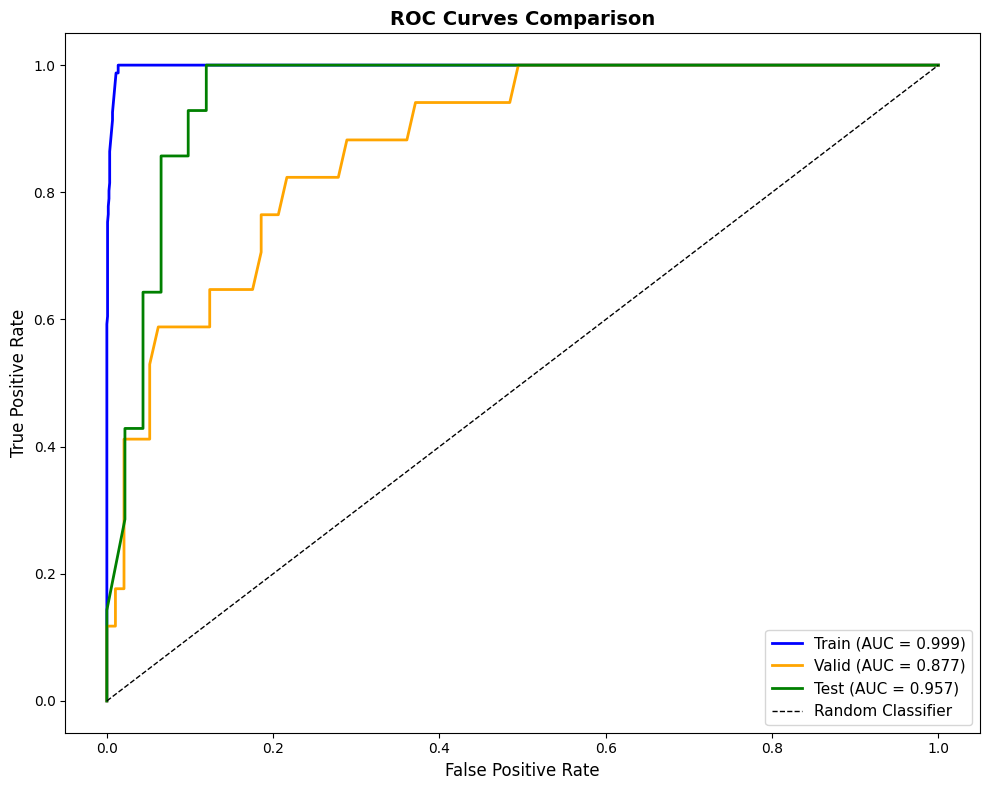

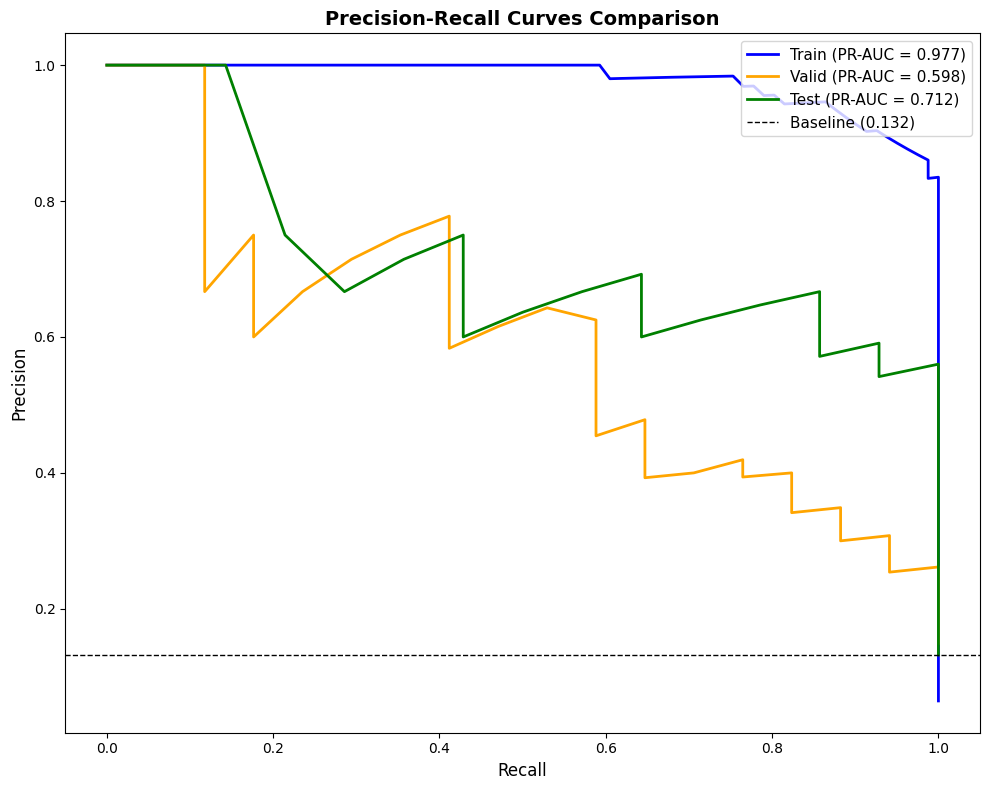

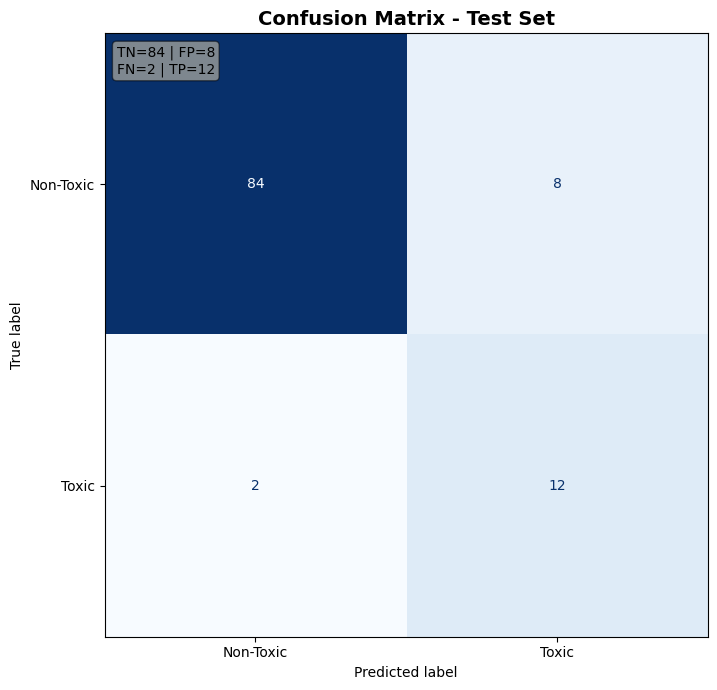

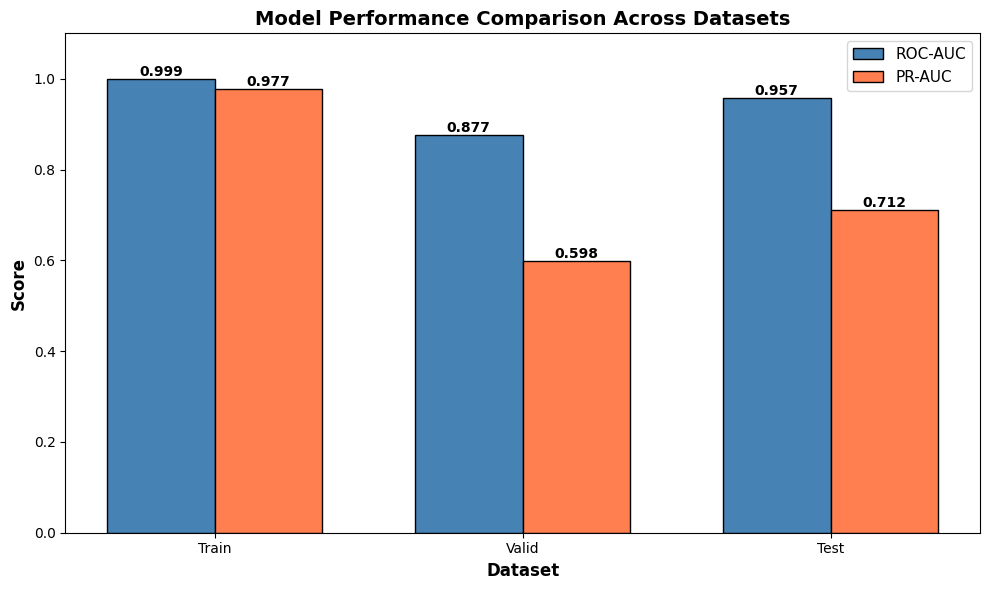

In [11]:
# =============================================================================
# 7. GRAPHICAL VISUALIZATIONS
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Generate predictions for train set (needed for plots)
y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= 0.5).astype(int)
train_prauc = average_precision_score(y_train, y_train_proba)
train_rocauc = roc_auc_score(y_train, y_train_proba)

# =============================================================================
# PLOT 1: ROC CURVES
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)
ax1.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_train:.3f})', linewidth=2, color='blue')

# Valid ROC
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
roc_auc_valid = auc(fpr_valid, tpr_valid)
ax1.plot(fpr_valid, tpr_valid, label=f'Valid (AUC = {roc_auc_valid:.3f})', linewidth=2, color='orange')

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)
ax1.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_test:.3f})', linewidth=2, color='green')

# Random classifier baseline
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('xgboost_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 2: PRECISION-RECALL CURVES
# =============================================================================
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Train PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
ax2.plot(recall_train, precision_train, label=f'Train (PR-AUC = {train_prauc:.3f})', linewidth=2, color='blue')

# Valid PR
precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_proba)
ax2.plot(recall_valid, precision_valid, label=f'Valid (PR-AUC = {valid_prauc:.3f})', linewidth=2, color='orange')

# Test PR
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
ax2.plot(recall_test, precision_test, label=f'Test (PR-AUC = {test_prauc:.3f})', linewidth=2, color='green')

# Baseline (proportion of positive class in test set)
baseline = y_test.sum() / len(y_test)
ax2.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})', linewidth=1)

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig('xgboost_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 3: CONFUSION MATRIX (TEST SET)
# =============================================================================
fig3, ax3 = plt.subplots(figsize=(8, 7))

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(cmap='Blues', ax=ax3, values_format='d', colorbar=False)
ax3.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
ax3.grid(False)

# Add text with metrics
tn, fp, fn, tp = cm_test.ravel()
metrics_text = f'TN={tn} | FP={fp}\nFN={fn} | TP={tp}'
ax3.text(0.02, 0.98, metrics_text, transform=ax3.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 4: METRICS COMPARISON BAR CHART
# =============================================================================
fig4, ax4 = plt.subplots(figsize=(10, 6))

datasets = ['Train', 'Valid', 'Test']
roc_scores = [train_rocauc, valid_rocauc, test_rocauc]
pr_scores = [train_prauc, valid_prauc, test_prauc]

x = np.arange(len(datasets))
width = 0.35

# Create bars for ROC-AUC and PR-AUC
bars1 = ax4.bar(x - width/2, roc_scores, width, label='ROC-AUC', color='steelblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, pr_scores, width, label='PR-AUC', color='coral', edgecolor='black')

ax4.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Model Performance Comparison Across Datasets', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(datasets)
ax4.legend(fontsize=11)
ax4.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('xgboost_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 4- Now that we see that our model works, we can replicate the same training but using larger data in train(train + valid)

In [12]:
df_train_full = add_fingerprints(df_train)
df_valid_full = add_fingerprints(df_valid)
df_test_full  = add_fingerprints(df_test)

# =============================================================================
# 3. PREPARE DATA FOR MODELING
# =============================================================================
drop_cols = ['SMILES', 'CT_TOX', 'FDA_APPROVED']

# Train
X_train = df_train_full.drop(drop_cols, axis=1)
y_train = df_train_full['CT_TOX']

# Valid
X_valid = df_valid_full.drop(drop_cols, axis=1)
y_valid = df_valid_full['CT_TOX']

# Test
X_test = df_test_full.drop(drop_cols, axis=1)
y_test = df_test_full['CT_TOX']

# Calculate Scale Pos Weight (Only with TRAIN)
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"3. Scale Pos Weight calculated (Train): {scale_weight:.2f}")

# =============================================================================
# 4. TRAIN FINAL MODEL WITH TRAIN + VALID
# =============================================================================
print("\n=== Training Final Model on Train + Valid ===")

# Combine the ALREADY FINGERPRINTED dataframes 
df_full_combined = pd.concat([df_train_full, df_valid_full], ignore_index=True)

X_full = df_full_combined.drop(drop_cols, axis=1)
y_full = df_full_combined['CT_TOX']

# Recalculate scale_pos_weight with combined data
scale_weight_full = (y_full == 0).sum() / (y_full == 1).sum()
print(f"Scale Pos Weight (Train+Valid): {scale_weight_full:.2f}")

# Use best hyperparameters
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.7,
    scale_pos_weight=scale_weight_full,
    objective='binary:logistic',
    eval_metric='aucpr',
    n_jobs=-1,
    random_state=42,
    tree_method='hist'
)

print("Training model...")
model.fit(X_full, y_full)

# =============================================================================
# 5. FINAL EVALUATION ON TEST SET
# =============================================================================
print("\n=== FINAL TEST SET EVALUATION ===")

y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_prauc = average_precision_score(y_test, y_test_proba)
test_rocauc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest PR-AUC:  {test_prauc:.4f}")
print(f"Test ROC-AUC: {test_rocauc:.4f}")
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred, target_names=['Non-Toxic', 'Toxic']))

# =============================================================================
# 6. SAVE MODEL
# =============================================================================
import joblib

model_filename = 'clintox_xgboost_final.pkl'
joblib.dump(model, model_filename)
print(f"\n✅ Model saved: {model_filename}")

# Save metadata
metadata = {
    'model_version': '1.0',
    'training_date': '2025-12-18',
    'test_prauc': test_prauc,
    'test_rocauc': test_rocauc,
    'scale_pos_weight': scale_weight_full,
    'hyperparameters': model.get_params(),
    'n_training_samples': len(X_full)
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadata saved: model_metadata.json")

[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerator
[17:22:37] DEPRECATION WARNING: please use MorganGenerat

3. Scale Pos Weight calculated (Train): 14.52

=== Training Final Model on Train + Valid ===
Scale Pos Weight (Train+Valid): 12.99
Training model...

=== FINAL TEST SET EVALUATION ===

Test PR-AUC:  0.7500
Test ROC-AUC: 0.9503

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.89      0.92        92
       Toxic       0.50      0.71      0.59        14

    accuracy                           0.87       106
   macro avg       0.73      0.80      0.75       106
weighted avg       0.89      0.87      0.88       106


✅ Model saved: clintox_xgboost_final.pkl
✅ Metadata saved: model_metadata.json
